In [1]:
import numpy as np
from numpy.testing import assert_allclose
from scipy.linalg import solve_sylvester   # for UUT closed form optimum
from time import perf_counter

import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8')  # make plots a bit nicer by default

# custom imports
from plot_utils import plot_matrix_evolution


# Set global constant NOTEBOOK_START_TIME. This block is idempotent.
if 'NOTEBOOK_START_TIME' in globals():
    print(f"Notebook start time: {NOTEBOOK_START_TIME:.2f}, which was {perf_counter() - NOTEBOOK_START_TIME:.2f} seconds ago.")  # type: ignore
else:
    NOTEBOOK_START_TIME = perf_counter()
    print(f"Notebook start time newly set to: {NOTEBOOK_START_TIME}")

Notebook start time newly set to: 737398.08550525


## To do / Questions

1. Experiments with resampled $w_0$ and/or $w_\star$
    * expectations over these, large $n$

2. Effect of different batch sizes

3. Visualize (2d) the direction of the learned mirror step compared to the GD step
    * is it still good after additional steps?

4. Optimization-style objective, rather than crossval

# Generating data

In [2]:
def generate_linear_data(d_feature: int, n_samples: int, w_cov: np.ndarray = None, noise_scale: float = 0.0) -> tuple[np.ndarray, np.ndarray, np.ndarray]:
    """
    Generates data y = Xw + e where X is (n_samples, d_feature) and w is (d_feature, 1).

    Args:
        d_feature: Dimension of feature space.
        n_samples: Number of samples to generate.
        w_cov: Covariance matrix for generating w. If None, uses identity matrix.
        noise_scale: Standard deviation of Gaussian noise.

    Returns:
        X: Feature matrix of shape (n_samples, d_feature).
        y: Target vector of shape (n_samples,).
        w: True weight vector of shape (d_feature,).
    """
    if w_cov is None:
        w_cov = np.eye(d_feature)
    
    w = np.random.multivariate_normal(mean=np.zeros(d_feature), cov=w_cov)
    X = np.random.randn(n_samples, d_feature)
    y = X @ w + np.random.normal(scale=noise_scale, size=(n_samples,))
    
    return X, y.ravel(), w


def generate_mixed_linear_data(d_feature: int, n_samples_per_w: int, n_ws: int, w_cov: np.ndarray = None, noise_scale: float = 0.0) -> tuple[np.ndarray, np.ndarray, np.ndarray]:
    """
    Generates data y = Xw + e for multiple w vectors.

    Args:
        d_feature: Dimension of feature space.
        n_samples_per_w: Number of samples to generate for each w.
        n_ws: Number of different w vectors to use.
        w_cov: Covariance matrix for generating w. If None, uses identity matrix.
        noise_scale: Standard deviation of Gaussian noise.

    Returns:
        X: Feature matrix of shape (n_ws * n_samples_per_w, d_feature).
        y: Target vector of shape (n_ws * n_samples_per_w,).
        W: Matrix of true weight vectors of shape (n_ws, d_feature).
    """
    if w_cov is None:
        w_cov = np.eye(d_feature)
    
    W = np.random.multivariate_normal(mean=np.zeros(d_feature), cov=w_cov, size=n_ws)
    X = np.random.randn(n_ws * n_samples_per_w, d_feature)
    y = np.concatenate([X[i * n_samples_per_w : (i+1) * n_samples_per_w] @ W[i] for i in range(n_ws)])
    y += np.random.normal(scale=noise_scale, size=y.shape)
    
    return X, y, W


def generate_specified_linear_data(n_samples_per_w: int, w_stars: np.ndarray, noise_scale: float = 0.0) -> tuple[np.ndarray, np.ndarray, np.ndarray]:
    """
    Generates data y = Xw + e for specified w vectors.

    Args:
        n_samples_per_w: Number of samples to generate for each w.
        w_stars: Array of weight vectors, shape (n_ws, d_feature).
        noise_scale: Standard deviation of Gaussian noise.

    Returns:
        X: Feature matrix of shape (n_ws * n_samples_per_w, d_feature).
        y: Target vector of shape (n_ws * n_samples_per_w,).
        W: Matrix of true weight vectors of shape (n_ws, d_feature).
    """
    n_ws, d_feature = w_stars.shape
    X = np.random.randn(n_ws * n_samples_per_w, d_feature)
    y = np.concatenate([X[i*n_samples_per_w:(i+1)*n_samples_per_w] @ w_stars[i] for i in range(n_ws)])
    y += np.random.normal(scale=noise_scale, size=y.shape)
    
    return X, y, w_stars


def generate_std_basis_data(d_feature: int, n_samples: int, w: np.ndarray = None) -> tuple[np.ndarray, np.ndarray, np.ndarray]:
    """
    Generates data y = Xw where X consists of standard basis vectors.

    Args:
        d_feature: Dimension of feature space.
        n_samples: Number of samples to generate (must be <= d_feature).
        w: True weight vector. If None, randomly generated.

    Returns:
        X: Feature matrix of shape (n_samples, d_feature).
        y: Target vector of shape (n_samples,).
        w: True weight vector of shape (d_feature,).
    """
    assert n_samples <= d_feature, "n_samples must be <= d_feature for standard basis vectors"
    
    if w is None:
        w = np.random.randn(d_feature)
    
    X = np.eye(d_feature)[:n_samples]
    y = (X @ w).ravel()
    
    return X, y, w


def generate_mixed_std_basis_data(d_feature: int, n_samples_per_w: int, n_ws: int, w_cov: np.ndarray = None, noise_scale: float = 0.0) -> tuple[np.ndarray, np.ndarray, np.ndarray]:
    """
    Generates data y = Xw + e for multiple w vectors, where X consists of standard basis vectors.

    Args:
        d_feature: Dimension of feature space.
        n_samples_per_w: Number of samples to generate for each w (must be <= d_feature).
        n_ws: Number of different w vectors to use.
        w_cov: Covariance matrix for generating w. If None, uses identity matrix.
        noise_scale: Standard deviation of Gaussian noise.

    Returns:
        X: Feature matrix of shape (n_ws * n_samples_per_w, d_feature).
        y: Target vector of shape (n_ws * n_samples_per_w,).
        W: Matrix of true weight vectors of shape (n_ws, d_feature).
    """
    assert n_samples_per_w <= d_feature, "n_samples_per_w must be <= d_feature for standard basis vectors"
    
    if w_cov is None:
        w_cov = np.eye(d_feature)
    
    W = np.random.multivariate_normal(mean=np.zeros(d_feature), cov=w_cov, size=n_ws)
    X = np.tile(np.eye(d_feature)[:n_samples_per_w], (n_ws, 1))
    y = np.concatenate([W[i, :n_samples_per_w] for i in range(n_ws)])
    y += np.random.normal(scale=noise_scale, size=y.shape)
    
    return X, y, W

# $Q$ parameterization: not ensuring psd or symmetric

## Basic training loop ✅

In [3]:
d, n = 3,1 
lr = 0.1
X, y, w_star = generate_linear_data(d, n)
Q0 = np.arange(d**2).reshape(d,d)
w0 = np.ones(d)

def mirror_update_single(w, Q, lr, x, y):
    return 2 * lr * (np.inner(w,x) - y) * (Q @ x)

def mirror_update_batch(w, Q, lr, X, y):
    return 2 * lr * Q @ X.T @ (X @ w - y)

sum = np.array([mirror_update_single(w0, Q0, lr, X[i], y[i]) for i in range(n)]).sum(0)
batch = mirror_update_batch(w0, Q0, lr, X, y)
print(sum, batch)

[-0.1944935  -0.13253337 -0.07057324] [-0.1944935  -0.13253337 -0.07057324]


In [4]:
def mirror_descent_step(w, Q, lr, x, y):
    return w - 2 * lr * (np.inner(w,x) - y) * (Q @ x)


def mirror_descent_batch_step(w: np.ndarray, Q: np.ndarray, lr: float, X: np.ndarray, y: float) -> np.ndarray:
    """
    Single step of mirror descent.

    Args:
        w: Current weight vector (d_feature, 1).
        Q: Potential matrix (d_feature, d_feature).
        lr: Learning rate.
        X: Data matrix (batch_size, d_feature)
        y: Target values (batch_size)

    Returns:
        Updated weight vector (d_feature,).
    """
    # TODO: dividing by norm isn't principled but makes single-step plots better. think about this.
    return w - 2 * lr * Q @ X.T @ (X @ w - y) / np.linalg.norm(Q)

def crossval(w: np.ndarray, Q: np.ndarray, lr: float, X: np.ndarray, y: np.ndarray,
             ignore_diag=True) -> float:
    """
    Perform leave-one-out cross-validation.

    For each (x_i, y_i) in the dataset:
    1. "Train" a model with a single step of mirror descent on (x_i, y_i)
    2. Evaluate it on the rest of the dataset

    Tested against non-vectorized version, performs identically.

    Args:
        w: Initial weight vector (d_feature,).
        Q: Potential matrix (d_feature, d_feature).
        lr: Learning rate.
        X: Feature matrix (n_samples, d_feature).
        y: Target vector (n_samples,).

    Returns:
        Average loss over all i, j with i != j.
    """
    n, d = X.shape

    errors = X @ w - y  # (n_samples,)
    XQX = X @ Q.T @ X.T  # (n_samples, n_samples)
    L_squared = (errors - 2 * lr * errors[:, np.newaxis] * XQX)**2  # (n_samples, n_samples)
    
    # Enforcing i != j condition, if applicable
    if ignore_diag:
        np.fill_diagonal(L_squared, 0)
        denom = 2 * n * (n-1)
    else:
        denom = 2 * n**2
    
    return np.sum(L_squared) / denom  # average over all L_ij

def potential_update(w: np.ndarray, Q: np.ndarray, outer_lr: float, inner_lr: float, X: np.ndarray, y: np.ndarray,
                     ignore_diag=True) -> np.ndarray:
    """
    Update the potential matrix Q based on the derivative of the cross-validation loss.

    Args:
        w: Current weight vector (d_feature,).
        Q: Current potential matrix (d_feature, d_feature).
        outer_lr: Learning rate for updating Q.
        inner_lr: Learning rate for the inner mirror descent step (η in the formula).
        X: Feature matrix (n_samples, d_feature).
        y: Target vector (n_samples,).

    Returns:
        Updated potential matrix Q (d_feature, d_feature).
    """
    n_samples = X.shape[0]
    
    errors = X @ w - y
    XQX = X @ Q.T @ X.T
    L = errors - 2 * inner_lr * errors[:, np.newaxis] * XQX
    
    if ignore_diag:
        np.fill_diagonal(L, 0)
        denom = n_samples * (n_samples - 1)
    else:
        denom = n_samples ** 2
    
    # Corrected matrix operations to match the original einsum
    L_errors = L.T * errors  # (n_samples, n_samples)
    update = X.T @ L_errors @ X  # (d_feature, d_feature)
    
    update *= -2 * inner_lr / denom
    return Q - outer_lr * update

### `potential_training_loop`

In [5]:
def potential_training_loop_Q(X, y, inner_lr, outer_lr, w0, Q0, n_iters):
    """
    Basic training loop/
    """
    n, d = X.shape
    crossvals = np.zeros(n_iters)
    Q = Q0.copy()
    Qs = np.zeros((n_iters, d, d))
    Qs[0] = Q.copy()
    for i in range(n_iters):
        crossvals[i] = crossval(w0, Q, inner_lr, X, y, ignore_diag=False)
        Q = potential_update(w0, Q, outer_lr, inner_lr, X, y, ignore_diag=False)
        Qs[i] = Q.copy()

    return crossvals, Qs


def generate_data_and_train_Q(d, n, inner_lr, outer_lr, w0, Q0, n_iters,
                              w_cov=None, noise_scale=0., seed=None):
    """
    Simpler training loop, which also generates data to eliminate another line of code later on. 
    """
    X, y, w_star = generate_linear_data(d, n, w_cov, noise_scale)
    crossvals, Qs = potential_training_loop_Q(X, y, inner_lr, outer_lr, w0, Q0, n_iters)

    return crossvals, Qs, X, y, w_star


def random_experiment_setup():
    d_feature = np.random.randint(5, 15)
    n_samples = np.random.randint(d_feature**1.25, d_feature**2.25)
    lr = np.random.uniform(0.01, 0.3)
    #noise_scale = np.random.uniform(0, 1)
    noise_scale = 0   # all noiseless for now

    X, y, w_star = generate_linear_data(d_feature, n_samples, noise_scale=noise_scale)

    w = np.random.randn(d_feature)
    Q = np.random.randn(d_feature, d_feature)

    return d_feature, n_samples, lr, X, y, w_star, w, Q

## Graphs for single $w$

### Closed-form solution

In [6]:
def stationary_closed_form(X, w, w_star, lr):
    z = w - w_star
    E = np.diag(X @ z)**2
    return np.outer(z, z) @ X.T @ X @ np.linalg.inv(X.T @ E @ X) / (2 * lr)


def stationarity_condition_Q_full(Q, X, w, w_star, lr, return_pair=False):
    errors = X @ (w - w_star)   # (n,)
    
    # TODO: would be nice to replace this einsum with something legible
    lhs = 2 * lr * np.einsum('j,ia,ab,jb,ik,jl->kl', errors**2, X, Q, X, X, X)

    XTe = X.T @ errors
    rhs = np.outer(XTe, XTe)  # (d,d)

    if return_pair:
        return lhs, rhs
    return lhs - rhs

#### Check correctness of closed-form solution

In [7]:
# set up Q_star
d, n, lr, X, y, w_star, w0, Q0 = random_experiment_setup()
Q_star = stationary_closed_form(X, w0, w_star, lr)

# check "stationarity condition"
lhs, rhs = stationarity_condition_Q_full(Q_star, X, w0, w_star, lr, return_pair=True)
assert_allclose(lhs, rhs)

# check empirically that it's stationary (next update step is ~no different)
outer_lr = 10 ** np.random.uniform(-3, -1)
assert_allclose(Q_star, potential_update(w0, Q_star, outer_lr, lr, X, y, ignore_diag=False))

In [8]:
# TODO: SHOULD MOVE OR DELETE THIS BLOCK

# # idea here: resample X a bunch of times with same cov (with distinctive subspace)
# # and then check if the top eigenvectors are aligned with each other, or something
# #  or generally, what properties of the resulting `stationary_closed_form` matrix are preserved / similar
# #
# # eigenvector thing seems mostly negative. a bit complicated by complex values, not sure what to make of that.

# X_cov = np.eye(d)
# for i in range(3):
#     X_cov[i,i] *= 1000

# d, n = 10, 100
# lr = 0.5
# w_star = np.ones(d)

# Qs, Xs, ws = [], [], []
# eigenvecs = []
# for i in range(8):
#     Xs.append(np.random.multivariate_normal(mean=np.zeros(d), cov=X_cov, size=(n,)))
#     ws.append(np.random.randn(d))
#     Qs.append(stationary_closed_form(Xs[-1], ws[-1], w_star, lr))

#     eigs = np.linalg.eig(Qs[-1])
#     absvals = np.abs(eigs.eigenvalues)
#     eigindex = np.argmax(absvals)
#     eigenvecs.append(eigs.eigenvectors[eigindex])

# eigenvecs = np.array(eigenvecs)
# xxT = eigenvecs @ np.conj(eigenvecs).T
# np.fill_diagonal(xxT, 0)
# plt.imshow(np.abs(xxT))  # i want to know if other vectors are aligned
# plt.colorbar()
# plt.show()

# # for i, Q in enumerate(Qs):

# #     plt.scatter(range(d), absvals)
# #     plt.title(f"{eigindex}")
# #     plt.show()

### Experiments

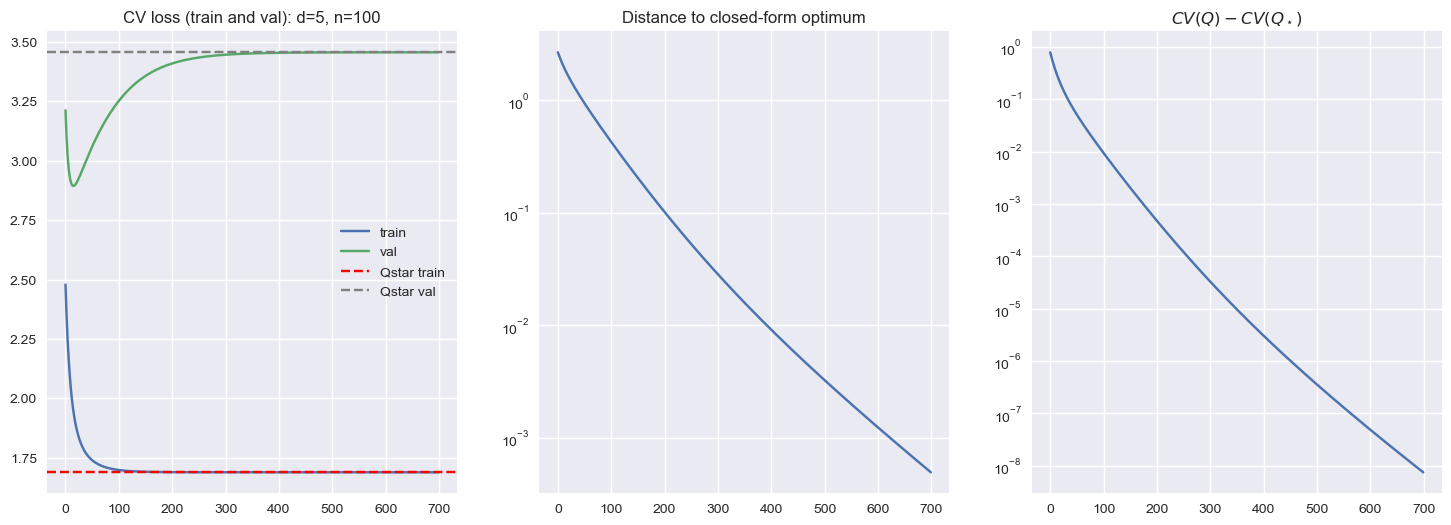

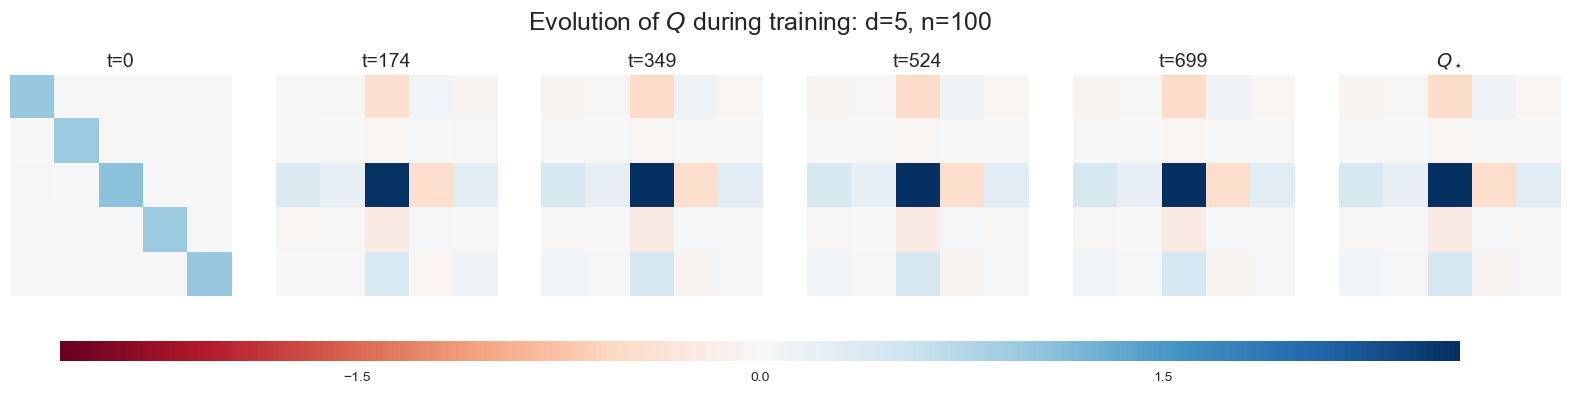

In [9]:
# Training setup
d,n = 5, 100
inner_lr, outer_lr = 0.1, 0.15
n_iters = 700
w_cov = np.eye(d)
w0 = np.ones(d)
Q0 = np.eye(d)

# Training loop
crossvals, Qs, X, y, w_star = generate_data_and_train_Q(n, inner_lr, outer_lr, w0, Q0, n_iters, w_cov, seed=123)

# --- Plots ---
n_figures = 3
r = range(n_iters)   # range of indices to plot, separated out for easy modification
#r = range(n_iters//2)

# Compute stationarity gaps, crossvals on validation data
X_val = np.random.randn(n, d)
validation_crossvals = np.array([crossval(w0, Q, inner_lr, X_val, X_val @ w_star, ignore_diag=False) for Q in Qs[r]])

# Compute distance to optimum
Qstar = stationary_closed_form(X, w0, w_star, inner_lr)
d_Q_Qstar = np.linalg.norm(Qs - Qstar, axis=(1,2))

plt.figure(figsize=(n_figures * 6, 6))
# Plot crossvals
plt.subplot(1, n_figures, 1)
plt.title(f"CV loss (train and val): d={d}, n={n}")
plt.plot(crossvals[r], label="train")
plt.plot(validation_crossvals[r], label="val")
plt.axhline(crossval(w0, Qstar, inner_lr, X, y, ignore_diag=False), label="Qstar train", linestyle='--', color='red')
plt.axhline(crossval(w0, Qstar, inner_lr, X_val, X_val @ w_star, ignore_diag=False), label="Qstar val", linestyle='--', color='gray')
plt.legend()

# plot distance to optimum
plt.subplot(1, n_figures, 2)
plt.title("Distance to closed-form optimum")
plt.plot(d_Q_Qstar[r])
plt.yscale('log')

# diff between CV and "optimal" CV
plt.subplot(1, n_figures, 3)
plt.title("$CV(Q) - CV(Q_\\star)$")
plt.plot(crossvals[r] - crossval(w0, Qstar, inner_lr, X, y, ignore_diag=False))
plt.yscale('log')
plt.show()

plot_matrix_evolution(Qs[r], extra_matrix=Qstar, extra_matrix_title="$Q_\\star$", main_title=f"Evolution of $Q$ during training: d={d}, n={n}")

## Compare to a single step of gradient descent

In [10]:
d,n = 5, 500
lr = 0.1
w_cov = np.eye(d)
w0 = np.ones(d)
Q0 = np.eye(d)

X, y, w_star = generate_linear_data(d, n, w_cov, noise_scale=0)
Qstar = stationary_closed_form(X, w0, w_star, lr)

trained_md_crossvals = []
gd_crossvals = []
X_vals = []
for i in np.arange(300):
    X_val = np.random.randn(n, d)
    y_val = X_val @ w_star
    trained_md_crossvals.append(crossval(w0, Qstar, lr, X_val, y_val))
    gd_crossvals.append(crossval(w0, np.eye(d), lr, X_val, y_val))
    X_vals.append(X_val)


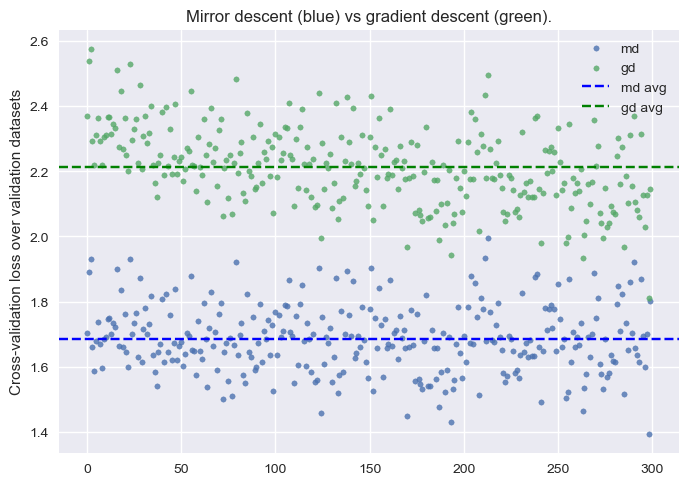

In [11]:
md_gd_crossvals = np.array([trained_md_crossvals, gd_crossvals])
sorted_indices = np.argsort(md_gd_crossvals[0])                        # sort by value of md crossval
sorted_indices = np.argsort(md_gd_crossvals[0] - md_gd_crossvals[1])   # sort by difference between crossvals
md_gd_crossvals = md_gd_crossvals[:, sorted_indices]
X_vals = np.array(X_vals)[sorted_indices]

plt.scatter(range(len(md_gd_crossvals[0])), md_gd_crossvals[0], label="md", s=15, alpha=0.8)
plt.scatter(range(len(md_gd_crossvals[0])), md_gd_crossvals[1], label="gd", s=15, alpha=0.8)
#plt.scatter(range(len(md_gd_crossvals[0])), md_gd_crossvals[1] - md_gd_crossvals[0], alpha=0.5, linestyle='--', color='gray', label="diffs", s=15)
plt.axhline(y=np.mean(md_gd_crossvals[0]), label="md avg", color='blue', linestyle='--')
plt.axhline(y=np.mean(md_gd_crossvals[1]), label="gd avg", color='green', linestyle='--')
plt.ylabel("Cross-validation loss over validation datasets")
plt.title("Mirror descent (blue) vs gradient descent (green).")
plt.legend()
plt.show()

[  10.   12.   14.   16.   19.   22.   26.   30.   36.   42.   49.   57.
   67.   79.   92.  108.  127.  149.  174.  204.  240.  281.  329.  386.
  452.  530.  621.  728.  853. 1000.]


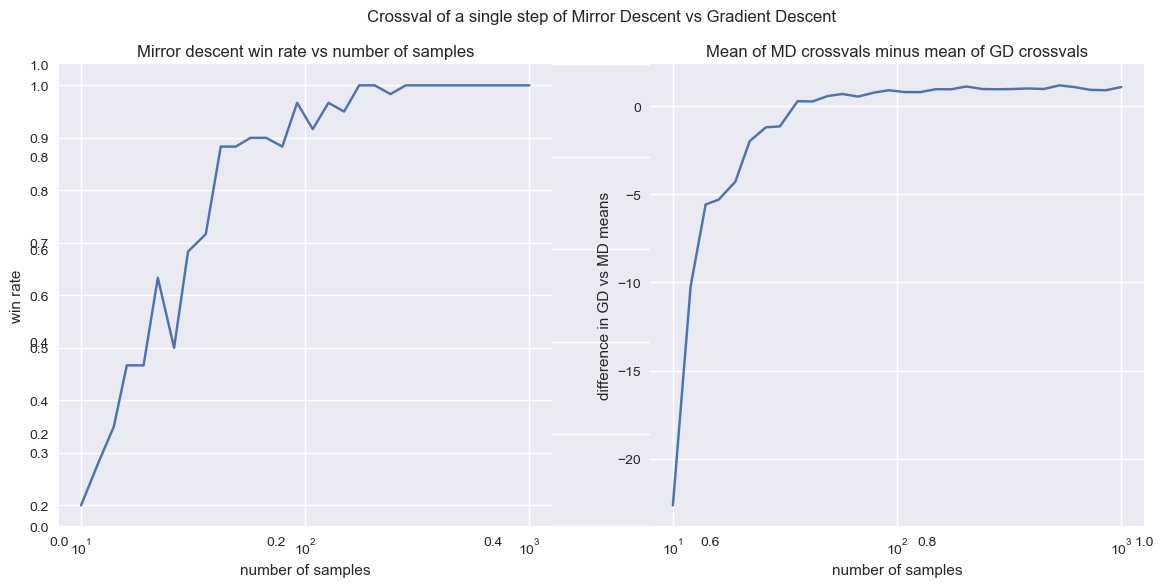

In [12]:
# n vs % of runs that MD wins
iters_per_size = 60
lr = 0.1
w0 = np.ones(d)

win_counts = []
mean_diffs = []

sizes = np.round(np.logspace(1, 3, 30))
print(sizes)
for n in sizes:
    n = int(n)
    qstar_crossvals = []
    gd_crossvals = []

    for i in np.arange(iters_per_size):
        X, y, w_star = generate_linear_data(d, n)
        Qstar = stationary_closed_form(X, w0, w_star, lr)

        X_val = np.random.randn(n, d)
        y_val = X_val @ w_star
        qstar_crossvals.append(crossval(w0, Qstar, lr, X_val, y_val))
        gd_crossvals.append(crossval(w0, np.eye(d), lr, X_val, y_val))

    md_gd_crossvals = np.array([qstar_crossvals, gd_crossvals])
    win_counts.append(np.mean(md_gd_crossvals[0] < md_gd_crossvals[1]))
    mean_diffs.append(np.mean(md_gd_crossvals[1] - md_gd_crossvals[0]))
    #print(f"Finished size n={n}")

plt.figure(figsize=(14, 6))
plt.title("Crossval of a single step of Mirror Descent vs Gradient Descent\n\n")
plt.subplot(1, 2, 1)
plt.plot(sizes, win_counts)
plt.xscale('log')
plt.xlabel("number of samples")
plt.ylabel("win rate")
plt.title("Mirror descent win rate vs number of samples")

plt.subplot(1, 2, 2)
plt.plot(sizes, mean_diffs)
plt.xscale('log')
plt.xlabel("number of samples")
plt.ylabel("difference in GD vs MD means")
plt.title("Mean of MD crossvals minus mean of GD crossvals")
plt.show()


### 2D plots: direction of MD vs GD step

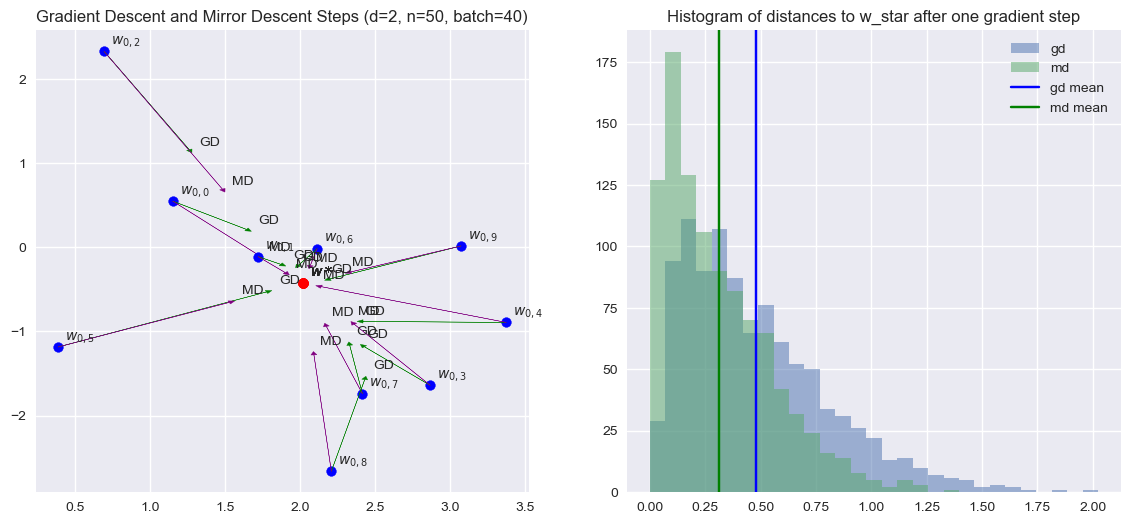

In [57]:
d,n = 2, 50
batch_size = 40
lr = 0.01
w_cov = np.eye(d)

X, y, w_star = generate_linear_data(d, n, w_cov, noise_scale=0)
Q0 = np.eye(d)

X = X[:batch_size]
y = y[:batch_size]
gd_distances = []
md_distances = []

n_points_to_plot = 10
plt.figure(figsize=(14, 6))
plt.subplot(1,2,1)
plt.title(f'Gradient Descent and Mirror Descent Steps (d={d}, n={n}, batch={batch_size})')
for i in range(1000):
    w0 = w_star + np.random.randn(d)
    Qstar = stationary_closed_form(X, w0, w_star, lr)
    gradient_step = mirror_descent_batch_step(w0, np.eye(d), lr, X, y)
    mirror_step = mirror_descent_batch_step(w0, Qstar, lr, X, y)

    gd_distances.append(np.linalg.norm(gradient_step - w_star))
    md_distances.append(np.linalg.norm(mirror_step - w_star))

    # only plot some points, show rest in histogram
    if i < n_points_to_plot:
        # Plot the original points
        plt.scatter(w0[0], w0[1], color='blue')
        plt.scatter(w_star[0], w_star[1], color='red')

        # Plot the step points
        #plt.scatter(gradient_step[0], gradient_step[1], color='green')
        #plt.scatter(mirror_step[0], mirror_step[1], color='purple')

        # Add arrows
        plt.arrow(w0[0], w0[1], gradient_step[0]-w0[0], gradient_step[1]-w0[1], 
                head_width=0.04, head_length=0.04, fc='green', ec='green', length_includes_head=True)
        plt.arrow(w0[0], w0[1], mirror_step[0]-w0[0], mirror_step[1]-w0[1], 
                head_width=0.04, head_length=0.04, fc='purple', ec='purple', length_includes_head=True)

        # Add labels
        plt.annotate(f'$w_{{0,{i}}}$', (w0[0], w0[1]), xytext=(5, 5), textcoords='offset points')
        plt.annotate('$w*$', (w_star[0], w_star[1]), xytext=(5, 5), textcoords='offset points')
        plt.annotate(f'GD', (gradient_step[0], gradient_step[1]), xytext=(5, 5), textcoords='offset points')
        plt.annotate('MD', (mirror_step[0], mirror_step[1]), xytext=(5, 5), textcoords='offset points')


max_dist = max(np.max(gd_distances), np.max(md_distances))
bins = list(np.linspace(0, max_dist, 30))
plt.subplot(1,2,2)
plt.hist(gd_distances, alpha=0.5, bins=bins, label="gd")
plt.hist(md_distances, alpha=0.5, bins=bins, label="md")
plt.axvline(np.mean(gd_distances), color="blue", label="gd mean")
plt.axvline(np.mean(md_distances), color="green", label="md mean")
plt.legend()
plt.title("Histogram of distances to w_star after one gradient step")
plt.show()

## Graphs for mixed $w$ / recovering covariance

Questions:
* Are there consistent, visible patterns in $Q$?
* What properties are preseved between multiple runs with different data?
* How does $\Sigma_w$ itself perform as a mirror map?

### Generic "run experiment" function

In [14]:
def potential_training_loop_mixed_w(d, n_samples_per_w, n_ws, inner_lr, outer_lr, w0, Q0, n_iters,
                                    w_cov=None, noise_scale=0.):
    
    X, y, W_stars = generate_mixed_linear_data(d, n_samples_per_w, n_ws, w_cov, noise_scale)

    Q = Q0.copy()
    crossvals = np.zeros(n_iters)
    Qs = np.zeros((n_iters, d, d))
    for i in range(n_iters):
        Qs[i] = Q.copy()
        crossvals[i] = crossval(w0, Q, inner_lr, X, y, ignore_diag=True)
        Q = potential_update(w0, Q, outer_lr, inner_lr, X, y, ignore_diag=False)

    return crossvals, Qs, X, y, W_stars

### Low-rank $\Sigma_w$

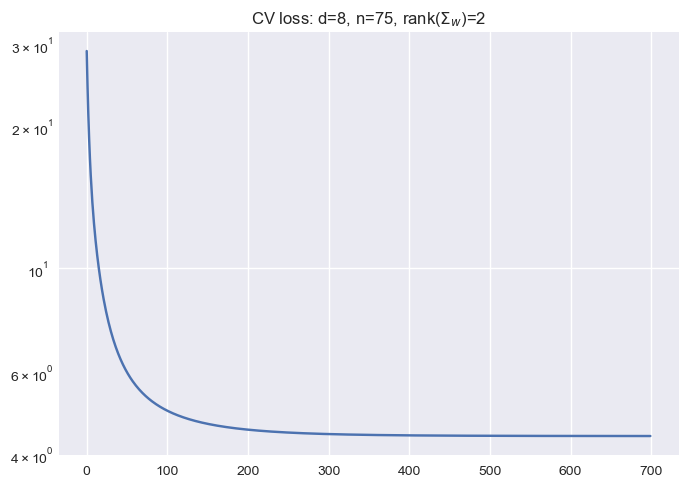

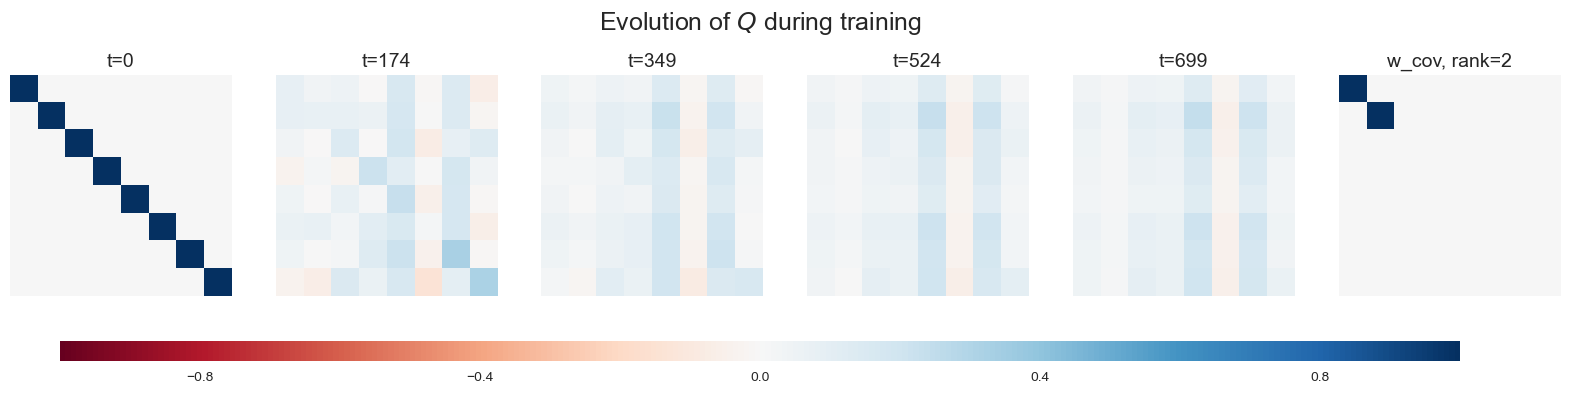

In [15]:
# other parameters for training
d, nspw, n_ws = 8, 3, 25  # nspw = n_samples_per_w
inner_lr, outer_lr = 0.3, 0.005
n_iters = 700
w0 = np.ones(d)
Q0 = np.eye(d)

# setting up w_cov
rank = 2
assert rank < d, f"rank {rank} should be less than dimension {d}"
w_cov = np.diag([1]*rank + [0]*(d-rank))

# Train potential
crossvals, Qs, X, y, W_stars = potential_training_loop_mixed_w(d, nspw, n_ws, inner_lr, outer_lr, w0, Q0, n_iters, w_cov)

# Plot crossvals
plt.plot(crossvals)
plt.title(f"CV loss: d={d}, n={nspw * n_ws}, rank($\\Sigma_w$)={rank}")
plt.yscale('log')

# Plot images of Q iterates over time
plot_matrix_evolution(Qs, extra_matrix=w_cov, extra_matrix_title=f'w_cov, rank={rank}', main_title='Evolution of $Q$ during training')

### Poorly-conditioned $\Sigma_w$

## Stationary-Point Conditions

### $L_{ij}$ stationary point condition: $x_j^\top Q x_i = z_j / (2 \eta z_i)$

In [16]:
# X_val = np.random.randn(n, d)

# sp_diffs = np.array([stationarity_condition_Q_Lij(Q, X, w0, w_star, lr) for Q in Qs])
# sp_diffs_val = np.array([stationarity_condition_Q_Lij(Q, X_val, w0, w_star, lr) for Q in Qs])

# mean_abs_diffs = np.mean(np.abs(sp_diffs), axis=(1,2))
# max_abs_diffs = np.max(np.abs(sp_diffs), axis=(1,2))
# min_abs_diffs = np.min(np.abs(sp_diffs), axis=(1,2))

# mean_abs_diffs_val = np.mean(np.abs(sp_diffs_val), axis=(1,2))
# max_abs_diffs_val= np.max(np.abs(sp_diffs_val), axis=(1,2))
# min_abs_diffs_val= np.min(np.abs(sp_diffs_val), axis=(1,2))

# #plt.plot(max_abs_diffs)
# plt.plot(mean_abs_diffs, label="train")
# plt.plot(mean_abs_diffs_val, label="val")
# plt.legend()
# #plt.plot(min_abs_diffs)
# plt.yscale('log')
# plt.show()


### Full-energy stationary-point condition

$$2\eta \sum_{i,j} \varepsilon_j (x_i^\top Q x_j) x_{ik}x_{j\ell}  = \sum_{i,j} \varepsilon_i \varepsilon_j x_{ik} x_{j\ell}.$$

In [17]:
# X_val = np.random.randn(n, d)
# lr = inner_lr

# sp_diffs = np.array([stationarity_condition_Q_full(Q, X, w0, w_star, lr) for Q in Qs])
# sp_diffs_val = np.array([stationarity_condition_Q_full(Q, X_val, w0, w_star, lr) for Q in Qs])

# mean_abs_diffs = np.mean(np.abs(sp_diffs), axis=(1,2))
# max_abs_diffs = np.max(np.abs(sp_diffs), axis=(1,2))
# min_abs_diffs = np.min(np.abs(sp_diffs), axis=(1,2))

# mean_abs_diffs_val = np.mean(np.abs(sp_diffs_val), axis=(1,2))
# max_abs_diffs_val= np.max(np.abs(sp_diffs_val), axis=(1,2))
# min_abs_diffs_val= np.min(np.abs(sp_diffs_val), axis=(1,2))

# #plt.plot(max_abs_diffs)
# plt.plot(mean_abs_diffs, label="train")
# plt.plot(mean_abs_diffs_val, label="val")
# plt.legend()
# #plt.plot(min_abs_diffs)
# plt.yscale('log')
# plt.show()

# $UU^\top$ parameterization

## Basic training loop

In [18]:
def mirror_descent_step_U(w: np.ndarray, U: np.ndarray, lr: float, x: np.ndarray, y: float) -> np.ndarray:
    """
    Single step of mirror descent.
    Just calls `mirror_descent_step` with `Q = U @ U.T`.

    [ 7.1: this function isn't actually used right now, since the potential update computes this manually ]

    Args:
        w: Current weight vector (d_feature, 1).
        U: Factor of potential matrix: Q = U @ U.T
        lr: Learning rate.
        x: Feature vector (d_feature,).
        y: Target value.

    Returns:
        Updated weight vector (d_feature,).
    """
    return mirror_descent_step(w, U @ U.T, lr, x, y)


def crossval_U(w: np.ndarray, U: np.ndarray, lr: float, X: np.ndarray, y: np.ndarray,
             ignore_diag=True) -> float:
    """
    Perform leave-one-out cross-validation.
    Just calls `crossval` with `Q = U @ U.T`.

    For each (x_i, y_i) in the dataset:
    1. "Train" a model with a single step of mirror descent on (x_i, y_i)
    2. Evaluate it on the rest of the dataset

    Tested against non-vectorized version, performs identically.

    Args:
        w: Initial weight vector (d_feature,).
        U: Factor of potential matrix: Q = U @ U.T
        lr: Learning rate.
        X: Feature matrix (n_samples, d_feature).
        y: Target vector (n_samples,).

    Returns:
        Average loss over all i, j with i != j.
    """
    return crossval(w, U @ U.T, lr, X, y, ignore_diag)

def potential_update_U(w: np.ndarray, U: np.ndarray, outer_lr: float, inner_lr: float, X: np.ndarray, y: np.ndarray,
                       ignore_diag=True) -> np.ndarray:
    """
    Update the potential matrix U based on the derivative of the cross-validation loss, where Q = UU^T.

    Args:
        w: Current weight vector (d_feature,).
        U: Current potential matrix factor (d_feature, d_feature).
        outer_lr: Learning rate for updating U.
        inner_lr: Learning rate for the inner mirror descent step (η in the formula).
        X: Feature matrix (n_samples, d_feature).
        y: Target vector (n_samples,).
        ignore_diag: Whether to ignore diagonal terms in the loss calculation.

    Returns:
        Updated potential matrix factor U (d_feature, d_feature).
    """
    n_samples = X.shape[0]
    denom = n_samples ** 2
    
    errors = X @ w - y
    L = errors - 2 * inner_lr * errors[:, np.newaxis] * X @ U @ U.T @ X.T
    
    if ignore_diag:
        np.fill_diagonal(L, 0)
        denom -= n_samples

    L_errors = L * errors[:, np.newaxis]  # (n_samples, n_samples)
    update = X.T @ (L_errors + L_errors.T) @ X @ U
    
    # Apply scaling factor
    update *= -2 * inner_lr / denom
    assert update.shape == U.shape, f"Potential update of shape {update.shape} is incompatible with U shape of {U.shape}."
    
    # Update U using gradient descent
    return U - outer_lr * update

In [19]:
def potential_training_loop_U(X, y, inner_lr, outer_lr, w0, U0, n_iters):
    """
    Basic training loop/
    """
    Us = [U0]
    crossvals = [crossval_U(w0, U0, inner_lr, X, y, ignore_diag=False)]
    U = U0.copy()
    for i in range(n_iters):
        U = potential_update_U(w0, U, outer_lr, inner_lr, X, y, ignore_diag=False)
        Us.append(U.copy())
        crossvals.append(crossval_U(w0, U, inner_lr, X, y, ignore_diag=False))

    Us = np.array(Us)
    crossvals = np.array(crossvals)

    return crossvals, Us, X, y, w_star 


def generate_data_and_train_U(d, n, inner_lr, outer_lr, w0, Q0, n_iters,
                              w_cov=None, noise_scale=0., seed=None):
    """
    Simpler training loop, which also generates data to eliminate another line of code later on. 
    """
    X, y, w_star = generate_linear_data(d, n, w_cov, noise_scale)
    crossvals, Us = potential_training_loop_U(X, y, inner_lr, outer_lr, w0, Q0, n_iters)

    return crossvals, Us, X, y, w_star

### Claude's numerical correctness check for `potential_update_U` 

In [20]:
from scipy.linalg import eigvalsh

def numerical_gradient(w, U, inner_lr, X, y, epsilon=1e-8):
    """Compute numerical gradient of CV loss with respect to U."""
    grad = np.zeros_like(U)
    for i in range(U.shape[0]):
        for j in range(U.shape[1]):
            U_plus = U.copy()
            U_plus[i, j] += epsilon
            U_minus = U.copy()
            U_minus[i, j] -= epsilon
            grad[i, j] = (crossval_U(w, U_plus, inner_lr, X, y) - 
                          crossval_U(w, U_minus, inner_lr, X, y)) / (2 * epsilon)
    return grad


def test_potential_update_U():
    # Generate random data
    n_samples, d_feature = 20, 5
    X = np.random.randn(n_samples, d_feature)
    w = np.random.randn(d_feature)
    y = X @ w + np.random.randn(n_samples) * 0.1
    U = np.random.randn(d_feature, d_feature)
    
    # Set learning rates
    outer_lr, inner_lr = 0.01, 0.1
    
    # Compute update using our function
    U_new = potential_update_U(w, U, outer_lr, inner_lr, X, y)
    actual_update = (U_new - U) / outer_lr
    
    # Compute numerical gradient
    numerical_grad = numerical_gradient(w, U, inner_lr, X, y)
    
    # Compare the results
    assert_allclose(actual_update, -numerical_grad, rtol=1e-4, atol=1e-4,
                    err_msg="Gradient from potential_update_U doesn't match numerical gradient")
    
    # Check if the resulting Q is positive semidefinite
    Q_new = U_new @ U_new.T
    min_eigenvalue = eigvalsh(Q_new).min()
    assert min_eigenvalue >= -1e-10, f"Resulting Q is not positive semidefinite. Min eigenvalue: {min_eigenvalue}"
    
    print("All tests passed!")

# Run the test
test_potential_update_U()

All tests passed!


## Closed-form optimum, stationarity conditions

In [21]:
def stationarity_condition_UUT_full(UUT, X, w, w_star, lr, return_pair=False):
    """
    Consistent with stationary_closed_form below.

    This check implicitly cancels the U on the end of the lhs and rhs.
    If you want to keep that U aruond, use `stationarity_condition_U_full`.
    """
    errors = X @ (w - w_star)  # (n,)
    E2 = np.diag(errors)**2  # (n, n)
    XTe = X.T @ errors  # (d,)
    xuuxe = X @ UUT @ X.T @ E2

    lhs = np.outer(XTe, XTe) # (d,d)
    rhs = lr * X.T @ (xuuxe + xuuxe.T) @ X
    if return_pair:
        return lhs, rhs
    return lhs - rhs 

def stationarity_condition_U_full(U, X, w, w_star, lr, return_pair=False):
    """
    Haven't directly tested this, but the UUT version works and is almost identical.
    
    This version doesn't implicitly cancel a U, so it might be preferable if you have access to U.
    """
    errors = X @ (w - w_star)  # (n,)
    E2 = np.diag(errors)**2  # (n, n)
    XTe = X.T @ errors  # (d,)
    xuuxe = X @ U @ U.T @ X.T @ E2

    lhs = np.outer(XTe, XTe) @ U # (d,d)
    rhs = lr * X.T @ (xuuxe + xuuxe.T) @ X @ U
    if return_pair:
        return lhs, rhs
    return lhs - rhs   


def stationary_closed_form_UUT(X, w, w_star, lr):
    """
    Currently passing all tests!

    Returns the matrix Q = UU^T that falls out of solving dCV/dU = 0.
    Assumptions: U, X^T E X, and X^T X are invertible.
    """
    n, d = X.shape

    # Define variables
    z = w - w_star
    E2 = np.diag(X @ z)**2   # E squared
    A = X.T @ X
    B = X.T @ E2 @ X
    A_inv = np.linalg.inv(A)
    
    # Set up and solve the Sylvester equation
    SA = A_inv @ B
    SB = B @ A_inv
    C = np.outer(z, z)
    UUT = solve_sylvester(SA, SB, C)
    return UUT / lr

In [22]:
def test_stationary_closed_form_U():
    d, n, lr = 5, 10, 0.1
    X, y, w_star = generate_linear_data(d, n)
    w0 = np.ones((d,))
    UUT_star = stationary_closed_form_UUT(X, w0, w_star, lr)
    lhs, rhs = stationarity_condition_UUT_full(UUT_star, X, w0, w_star, lr, return_pair=True)
    try:
        assert_allclose(lhs, rhs)
    except AssertionError as e:
        print("assert_allclose failed: Closed-form matrix isn't passing stationary condition.")
        print(e) 

test_stationary_closed_form_U()

## Graphs for single $w$

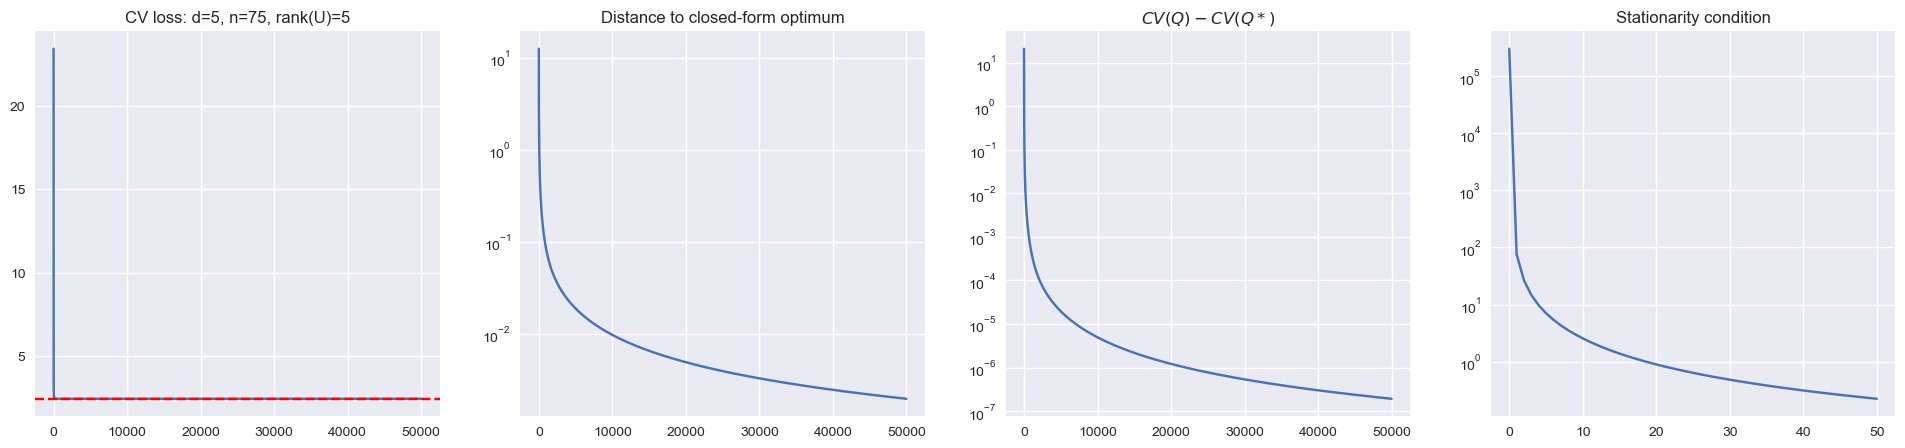

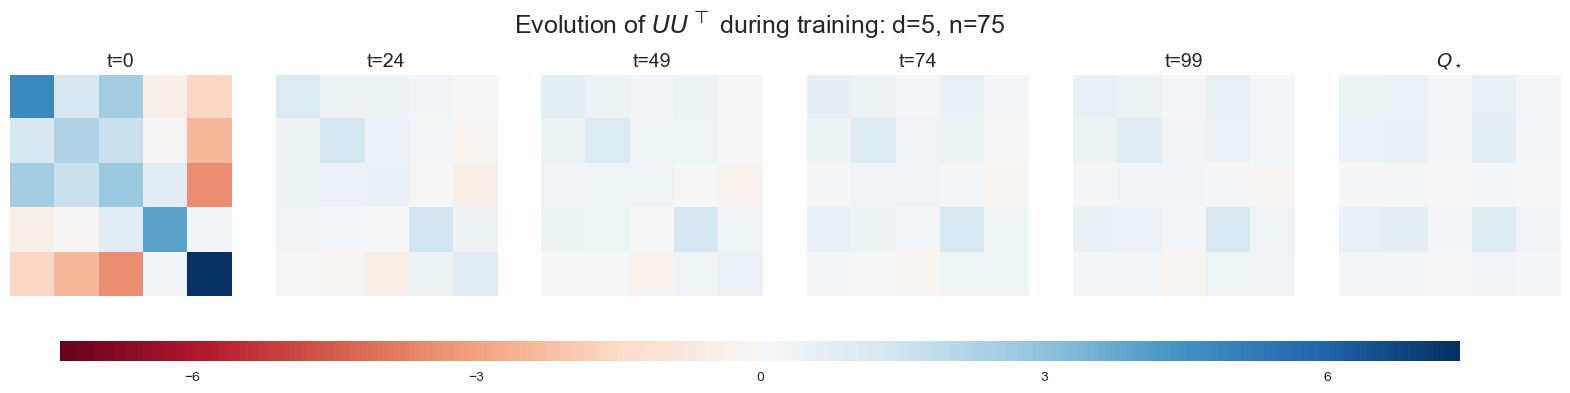

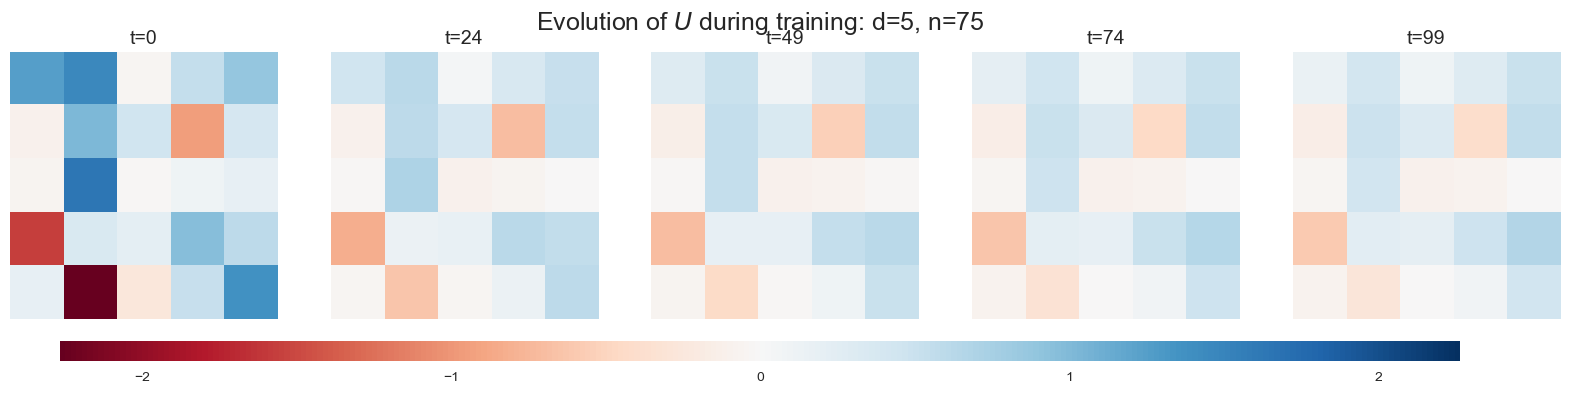

In [58]:
# Training setup
d,n = 5, 75
rank = 5
inner_lr, outer_lr = 0.1, 0.03
n_iters = 50000
w_cov = np.eye(d)
w0 = np.ones(d)
U0 = 0.0001 * np.eye(d)
U0 =  np.random.randn(d, rank) 

# Training loop
crossvals, Us, X, y, w_star = generate_data_and_train_U(d, n, inner_lr, outer_lr, w0, U0, n_iters, w_cov)

UUTstar = stationary_closed_form_UUT(X, w0, w_star, inner_lr)
UUTs = np.array([U @ U.T for U in Us])

# Compute distance to optimum
d_UUT_UUTstar = np.linalg.norm(UUTs - UUTstar, axis=(1,2))
r = range(n_iters)

# Plot crossvals
plt.figure(figsize=(24, 5))
plt.subplot(1, 4, 1)
plt.title(f"CV loss: d={d}, n={n}, rank(U)={rank}")
plt.plot(crossvals[r], label="train")
plt.axhline(crossval(w0, UUTstar, inner_lr, X, y, ignore_diag=False), label="Qstar train", linestyle='--', color='red')

# plot distance to optimum
plt.subplot(1, 4, 2)
plt.title("Distance to closed-form optimum")
plt.plot(d_UUT_UUTstar[r])
plt.yscale('log')

# diff between CV and UUTstar CV
plt.subplot(1, 4, 3)
plt.title("$CV(Q) - CV(Q*)$")
plt.plot((crossvals[r] - crossval(w0, UUTstar, inner_lr, X, y, ignore_diag=False)))
plt.yscale('log')

# stationarity condition. More to test the condition than anything else.
plt.subplot(1, 4, 4)
plt.title("Stationarity condition")
plt.plot([np.linalg.norm(stationarity_condition_U_full(U, X, w0, w_star, inner_lr)) for U in Us[::n_iters//50]])
plt.yscale('log')
plt.show()

r = range(100)
plot_matrix_evolution(UUTs[r], main_title=f"Evolution of $UU^\\top$ during training: d={d}, n={n}", extra_matrix=UUTstar, extra_matrix_title=f"$Q_\\star$")
plot_matrix_evolution(Us[r], main_title=f"Evolution of $U$ during training: d={d}, n={n}")

### Eigenvalue / singular value alignment

In [56]:
U, S, V = np.linalg.svd(UUTstar)
print(S)
print(np.inner(w_star, U))
print(U[:,-1])
print(w_star)

[1.66322384e+00 1.96882172e-02 2.35384874e-04 6.10043391e-07
 9.65555451e-11]
[-1.56921037 -1.16300584 -1.02187307  0.76039826  0.65836098]
[ 0.06699838  0.39728503 -0.09318365 -0.47977345  0.77382819]
[ 0.3856957   1.43636362 -1.85896569 -0.30996904 -0.3273181 ]


### Effect of initialization on $UU^T_\star$

TODO: QUESTION

observation: $U$ evolution looks like a suspicious amount of "structure" in the random initialization is preserved later on (even when $UU^\top$ is very close to $Q_\star$).

experiment: fix $X, y, w_0$ and vary $U_0$. Do you get different $U_{final}$ but same $UU^\top$?

In [ ]:
# Training setup
d,n = 5, 75
rank = 5
inner_lr, outer_lr = 0.1, 0.03
n_iters = 50000
w_cov = np.eye(d)
w0 = np.ones(d)

# Generate *fixed* data for several training loops
w = np.random.multivariate_normal(mean=np.zeros(d), cov=w_cov)
X = np.random.randn(n, d)
y = X @ w + np.random.normal(scale=0, size=(n,))

crossvals, Us, X, y, w_star = generate_data_and_train_U(d, n, inner_lr, outer_lr, w0, U0, n_iters, w_cov)
U0 = 0.0001 * np.eye(d)
U0 =  np.random.randn(d, rank) 

UUTstar = stationary_closed_form_UUT(X, w0, w_star, inner_lr)
UUTs = np.array([U @ U.T for U in Us])

# Compute distance to optimum
d_UUT_UUTstar = np.linalg.norm(UUTs - UUTstar, axis=(1,2))
r = range(n_iters)

# Plot crossvals
plt.figure(figsize=(24, 5))
plt.subplot(1, 4, 1)
plt.title(f"CV loss: d={d}, n={n}, rank(U)={rank}")
plt.plot(crossvals[r], label="train")
plt.axhline(crossval(w0, UUTstar, inner_lr, X, y, ignore_diag=False), label="Qstar train", linestyle='--', color='red')

# plot distance to optimum
plt.subplot(1, 4, 2)
plt.title("Distance to closed-form optimum")
plt.plot(d_UUT_UUTstar[r])
plt.yscale('log')

# diff between CV and UUTstar CV
plt.subplot(1, 4, 3)
plt.title("$CV(Q) - CV(Q*)$")
plt.plot((crossvals[r] - crossval(w0, UUTstar, inner_lr, X, y, ignore_diag=False)))
plt.yscale('log')

# stationarity condition. More to test the condition than anything else.
plt.subplot(1, 4, 4)
plt.title("Stationarity condition")
plt.plot([np.linalg.norm(stationarity_condition_U_full(U, X, w0, w_star, inner_lr)) for U in Us[::n_iters//50]])
plt.yscale('log')
plt.show()

r = range(100)
plot_matrix_evolution(UUTs[r], main_title=f"Evolution of $UU^\\top$ during training: d={d}, n={n}", extra_matrix=UUTstar, extra_matrix_title=f"$Q_\\star$")
plot_matrix_evolution(Us[r], main_title=f"Evolution of $U$ during training: d={d}, n={n}")

## Graphs for mixed $w$ / recovering covariance

# ANNEX. 
**Code that's likely temporary, and I don't want it to be in the way anywhere else. Proceed with caution.**

### Inefficient Sylvester equation solver
Use matrix-vector form of the Sylvester equation to solve "by hand".

Advantages:
* Very easy to see what's going on.

Disadvantages:
* $O((mn)^3)$ runtime
* $O((mn)^2)$ space to store Kronecker product
* Examples that take scipy less than a second will nearly crash my computer if given to my implementation (e.g. 300 x 400)

In [25]:
def my_sylvester(A, B, C):
    n, m = C.shape
    In, Im = np.eye(n), np.eye(m)
    kron = np.kron(Im, A) + np.kron(B.T, In)
    print(kron.shape)
    vec_C = C.T.flatten()

    vec_X = np.linalg.solve(kron, vec_C)
    return vec_X.reshape(m, n).T

m, n = 10, 20
A = np.random.randn(n,n)
B = np.random.randn(m,m)
C = np.random.randn(n,m)
start = perf_counter()
myX = my_sylvester(A, B, C)
mid = perf_counter()
sciX = solve_sylvester(A, B, C)
end = perf_counter()

assert_allclose(myX, sciX)
print(f"My implementation: {mid - start:.8f}")
print(f"Scipy implementation: {end - mid:.8f}")

(200, 200)
My implementation: 0.00393067
Scipy implementation: 0.00727317


# final cell

In [26]:
print(f"Time elapsed: {perf_counter() - NOTEBOOK_START_TIME:.2f} seconds")

Time elapsed: 9.16 seconds
